<a href="https://colab.research.google.com/github/estoymukundjha/Energy-Application-Prediction/blob/main/Appliance_Energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime as dt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [51]:
data = pd.read_csv("/content/drive/MyDrive/Data/data_application_energy.csv")

In [52]:
df = pd.DataFrame(data)

##Understanding the data

In [60]:
df.tail()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,23.20,52.400000,24.796667,1.0,24.500000,44.500000,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,23.23,52.326667,24.196667,1.0,24.557143,44.414286,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,23.23,52.266667,23.626667,1.0,24.540000,44.400000,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,23.20,52.200000,22.433333,1.0,24.500000,44.295714,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,23.20,52.200000,21.026667,1.0,24.500000,44.054000,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [54]:
df.shape

(19735, 29)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [56]:
df.isna().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [57]:
#Checking for duplicates
duplicate_df = df[df.duplicated()]
duplicate_df

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2


In [58]:
df.describe(include='all')

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
unique,19735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2016-04-05 04:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,NaN,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,NaN,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,NaN,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,NaN,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,NaN,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769


In [63]:
#from datetime import datetime

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

##Downcasting

In [64]:
# Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d %H:%M:%S')
    return df
                
df = downcast(df)

####Seprating different columns

In [65]:
temperature = df[["T1","T2","T3","T4","T5","T6","T7","T8","T9"]]

weather = df[["T_out", "Tdewpoint","RH_out","Press_mm_hg", "Windspeed","Visibility"] ]

light = df[["lights"]]

humidity = df[["RH_1","RH_2","RH_3","RH_4","RH_5","RH_6","RH_7","RH_8","RH_9"]]

randoms = df[["rv1", "rv2"]]

date = df['date']

X = df.drop(labels=['Appliances','date'], axis = 1)
Y = df["Appliances"]

#Exploratory Data Analysis

####Univariate

In [66]:
dataVisual = df.drop(['rv1', 'rv2'], axis=1)

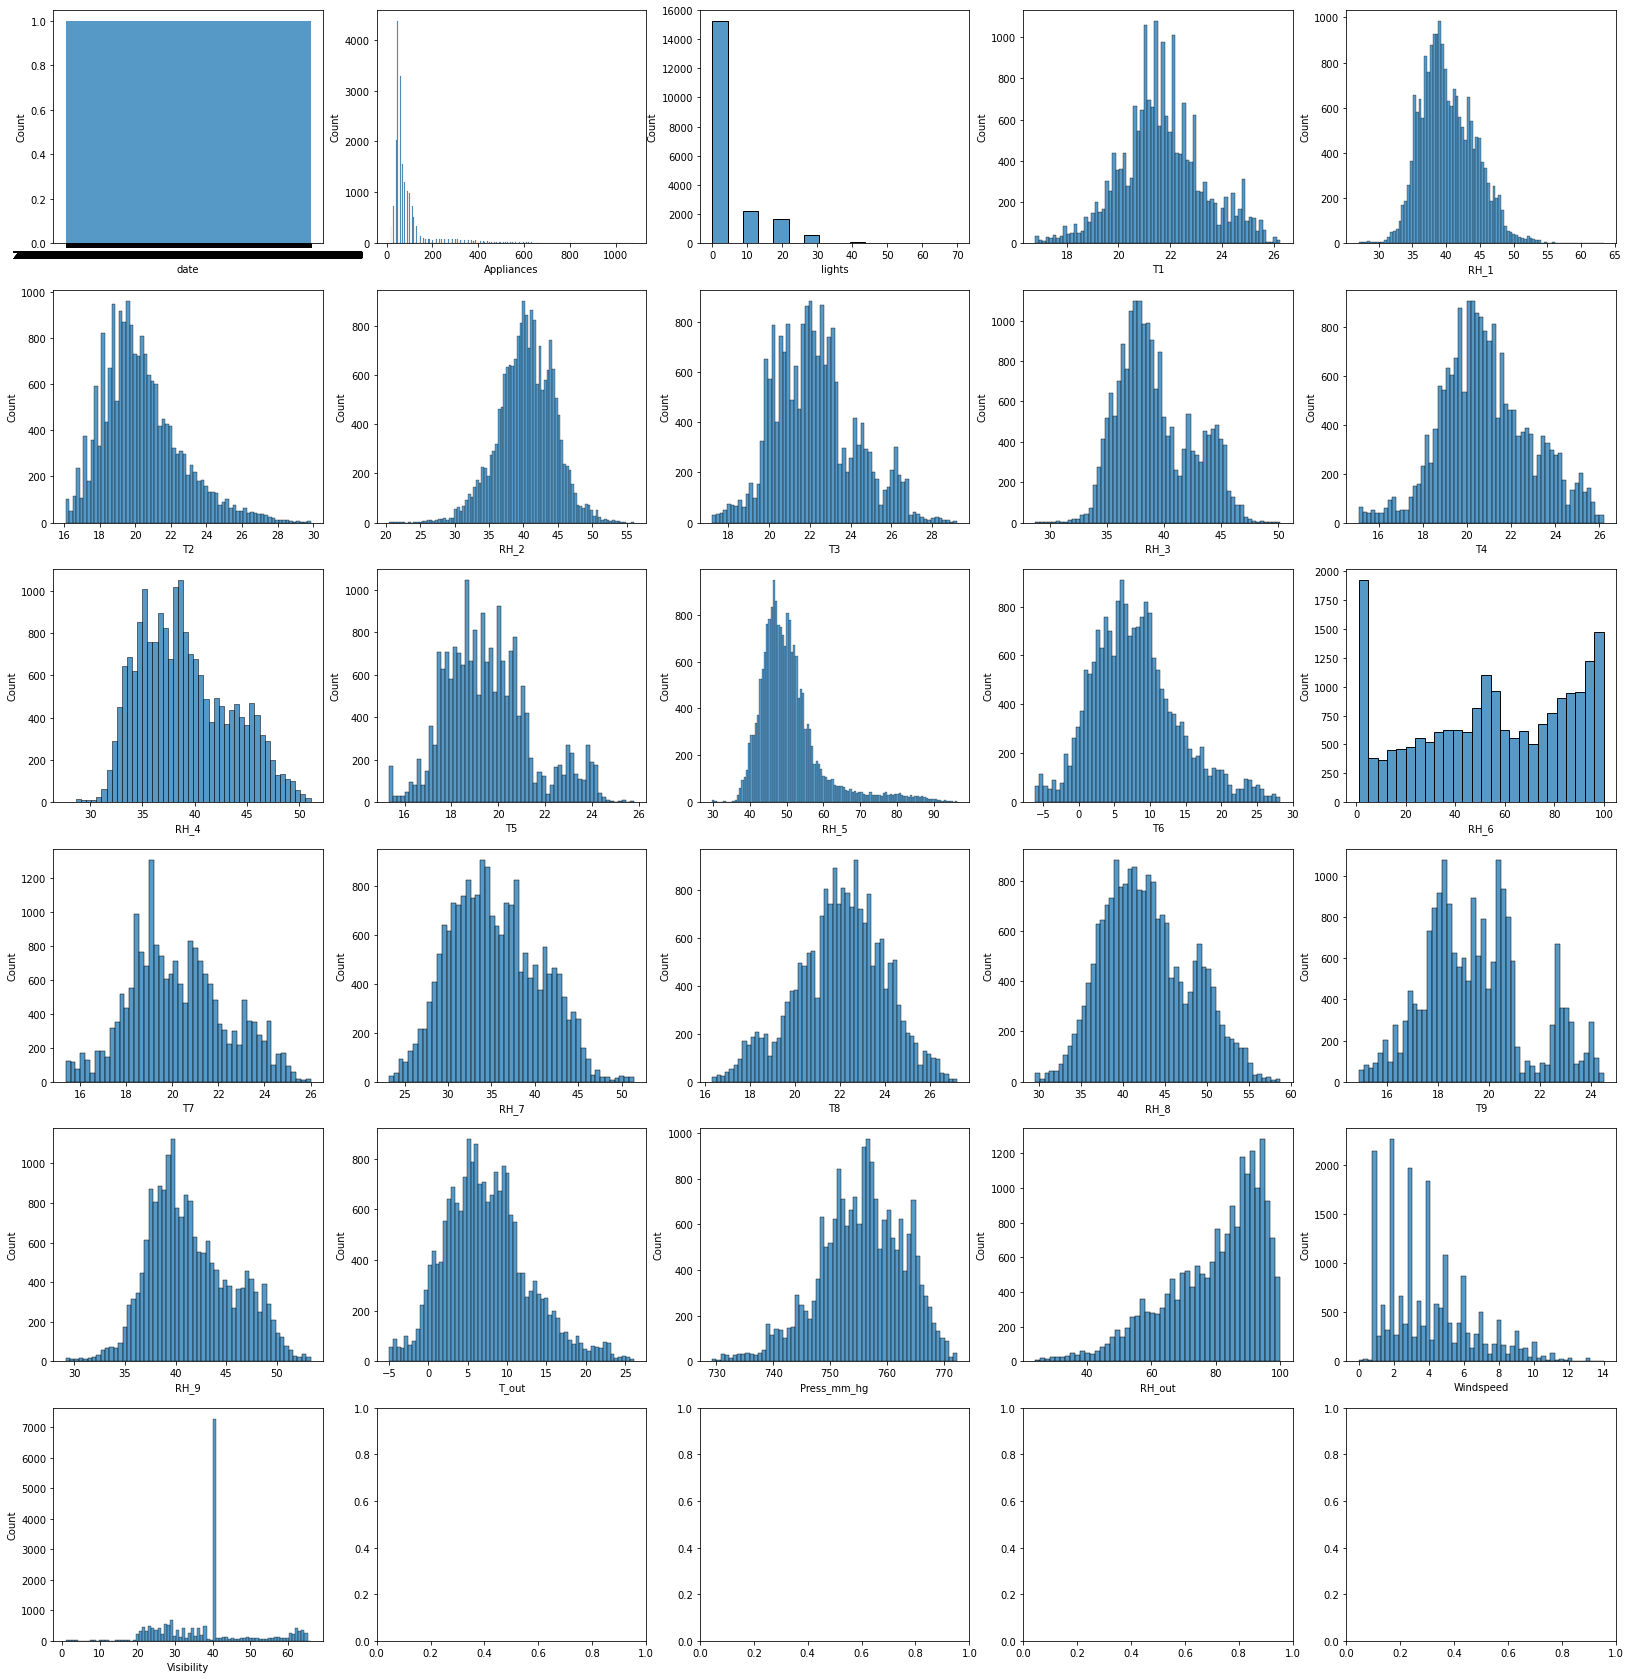

In [ ]:
# Distribution plot for each features

ls = []
colName = [j for j in dataVisual.columns]
a = 0
while a < 7:
    for i in range(5):
        ls.append((a, i))
    a+=1
fig, ax = plt.subplots(6, 5, figsize=(28, 30))
for k in range(26):
    sns.histplot(ax=ax[ls[k][0], ls[k][1]], x=colName[k], data=dataVisual)

In [67]:
import plotly.express as px

In [68]:
edadf = df.copy()
edadfsmall = df[0:2467].copy()

#### Appliances vs Light

In [69]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces

fig.add_trace(
    go.Scatter(x=edadfsmall['date'], y=edadfsmall['Appliances'], 
               name="Appliances",
               mode='lines'),
    secondary_y=False,
)



fig.add_trace(
    go.Scatter(x=edadfsmall['date'], y=edadfsmall['lights'], 
               name='lights',
               mode='lines'),
    secondary_y=True,
)

fig.update_layout(
    title='Appliance and Light usage over two weeks',
    xaxis_title="Date")
    
fig.update_yaxes(title_text="Appliance Usage (in Wh)", secondary_y=False, color="blue")
fig.update_yaxes(title_text="Lights Usage (in Wh)", secondary_y=True, color="red")
    
fig.show()

#### Appliances vs Temperature

In [70]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x=edadfsmall['date'], y=edadfsmall['Appliances'], 
               name="Appliances",
               mode='lines'),
    secondary_y=False,
)
tempcolumns = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T_out']

for i in tempcolumns:
    fig.add_trace(
        go.Scatter(x=edadfsmall['date'], y=edadfsmall[i], 
                   name=i,
                   mode='lines'),
        secondary_y=True,
    )

fig.update_layout(
    title='Appliance usage and Temperature over two weeks',
    xaxis_title="Date")
    
fig.update_yaxes(title_text="Appliance Usage (in Wh)", secondary_y=False, color="blue")
fig.update_yaxes(title_text="Temperature (in Celsius)", secondary_y=True)    
    
fig.show()


##Appliances and Humidity

In [71]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces

fig.add_trace(
    go.Scatter(x=edadfsmall['date'], y=edadfsmall['Appliances'], 
               name="Appliances",
               mode='lines'),
    secondary_y=False,
)
humiditycolumns = ['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9', 'RH_out']

for i in humiditycolumns:
    fig.add_trace(
        go.Scatter(x=edadfsmall['date'], y=edadfsmall[i], 
                   name=i,
                   mode='lines'),
        secondary_y=True,
    )

fig.update_layout(
    title='Appliance usage and Humidity over two weeks',
    xaxis_title="Date")
    
fig.update_yaxes(title_text="Appliance Usage (in Wh)", secondary_y=False, color="blue")
fig.update_yaxes(title_text="humidity (in %)", secondary_y=True)    
    
fig.show()


##Appliances and Outside Variables

In [72]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces

fig.add_trace(
    go.Scatter(x=edadfsmall['date'], y=edadfsmall['Appliances'], 
               name="Appliances",
               mode='lines'),
    secondary_y=False,
)
humiditycolumns = ['T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint']

for i in humiditycolumns:
    fig.add_trace(
        go.Scatter(x=edadfsmall['date'], y=edadfsmall[i], 
                   name=i,
                   mode='lines'),
        secondary_y=True,
    )
    
fig.update_layout(
    title='Appliance and Outside Variables over two weeks',
    xaxis_title="Date")
    
fig.update_yaxes(title_text="Appliance Usage (in Wh)", secondary_y=False, color="blue")
fig.update_yaxes(title_text="Arbitrary values", secondary_y=True)

fig.show()

##Appliances and Random Variables

In [73]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces

fig.add_trace(
    go.Scatter(x=edadfsmall['date'], y=edadfsmall['Appliances'], 
               name="Appliances",
               mode='lines'),
    secondary_y=False,
)
humiditycolumns = ['rv1', 'rv2']

for i in humiditycolumns:
    fig.add_trace(
        go.Scatter(x=edadfsmall['date'], y=edadfsmall[i], 
                   name=i,
                   mode='lines'),
        secondary_y=True,
    )
    
fig.update_layout(
    title='Appliance usage and Random variables over two weeks',
    xaxis_title="Date")
    
fig.update_yaxes(title_text="Appliance Usage (in Wh)", secondary_y=False, color="blue")
fig.update_yaxes(title_text="arbitrary value", secondary_y=True)

fig.show()

In [74]:
fedf = df.copy()

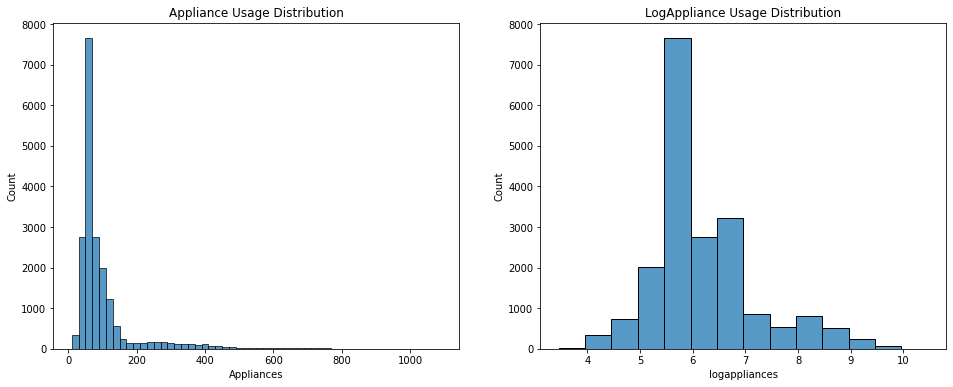

In [75]:
df['logappliances'] = df['Appliances'].apply(lambda x: np.log2(x+1))

fig, ax = plt.subplots(1,2, figsize=(16,6))

sns.histplot(x='Appliances', data=df, binwidth=20, ax=ax[0])
sns.histplot(x='logappliances', data=df, binwidth=0.5, ax=ax[1])

ax[0].set_title('Appliance Usage Distribution')
ax[1].set_title('LogAppliance Usage Distribution')

plt.show()

In [77]:
lags = [1,3,6,18,36,144]
for lag in lags:
    df['logappliances_lag_'+str(lag)] = df['logappliances'].shift(lag).astype(np.float16)
    
# remove null values created by lag
df = df.iloc[144:]

In [78]:
import datetime as dt

In [80]:
df['month'] = df['date'].dt.month
df['day_of_month'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['day_of_year'] = df['date'].dt.dayofyear

# drop date
df = df.drop(columns=['date'], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

##Modeling

In [81]:
dfm = df.drop(['Appliances'], axis=1)

In [82]:
X_train, y_train = dfm[dfm['day_of_year'] < 109].drop('logappliances', axis=1), dfm[dfm['day_of_year'] < 109]['logappliances']
X_valid = dfm[(dfm['day_of_year']>= 109) & (dfm['day_of_year'] < 123)].drop('logappliances',axis=1)
y_valid = dfm[(dfm['day_of_year']>= 109) & (dfm['day_of_year'] < 123)]['logappliances']
X_test, y_test = dfm[dfm['day_of_year'] >= 123].drop('logappliances',axis=1), dfm[dfm['day_of_year'] >= 123]['logappliances']

# drop day of year (acted as an id for each row to split data)
X_train = X_train.drop(columns=['day_of_year'], axis=1)
X_valid = X_valid.drop(columns=['day_of_year'], axis=1)
X_test = X_test.drop(columns=['day_of_year'], axis=1)

In [83]:
logcolumns = ['logappliances_lag_1', 'logappliances_lag_3',
              'logappliances_lag_6', 'logappliances_lag_18', 
              'logappliances_lag_36', 'logappliances_lag_144']

X_trainnolag = X_train.copy().drop(columns=logcolumns, axis=1)
X_validnolag = X_valid.copy().drop(columns=logcolumns, axis=1)
X_testnolag = X_test.copy().drop(columns=logcolumns, axis=1)

In [84]:
results = pd.DataFrame(columns=['feature', 'model', 'train rmse', 'valid rmse'])

def addresult(feature, model, trainrmse, validrmse):
    modelname = type(model).__name__
    return {'feature':feature, 'model':modelname, 'train rmse':trainrmse, 'valid rmse':validrmse}

In [85]:
lbgm = LGBMRegressor()
lbgm.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
         eval_metric='rmse', verbose=None, early_stopping_rounds=20)
lbgmresults = list(lbgm.best_score_.items())
results = results.append(addresult('lag', lbgm, lbgmresults[0][1]['rmse'], 
                                   lbgmresults[1][1]['rmse']), ignore_index=True)


lbgmnolag = LGBMRegressor()
lbgmnolag.fit(X_trainnolag, y_train, eval_set=[(X_trainnolag, y_train), (X_validnolag, y_valid)],
              eval_metric='rmse', verbose=None, early_stopping_rounds=20)
lbgmnolagresults = list(lbgmnolag.best_score_.items())
results = results.append(addresult('no lag', lbgmnolag, lbgmnolagresults[0][1]['rmse'], 
                                   lbgmnolagresults[1][1]['rmse']), ignore_index=True)


models = [SVR(), RandomForestRegressor(random_state=1)]

def evalmodel(model, xtrain, ytrain, xvalid, yvalid):
    mod = model
    mod.fit(xtrain, ytrain)
    rmsetrain = round(mean_squared_error(ytrain, mod.predict(xtrain), squared=False),3)
    rmsevalid = round(mean_squared_error(yvalid, mod.predict(xvalid), squared=False),3)
    return rmsetrain, rmsevalid

for i in models:
    rmsetrain, rmsevalid = evalmodel(i, X_train, y_train, X_valid, y_valid)
    results = results.append(addresult('lag', i, rmsetrain, rmsevalid), ignore_index=True)
    rmsetrain, rmsevalid = evalmodel(i, X_trainnolag, y_train, X_validnolag, y_valid)
    results = results.append(addresult('no lag', i, rmsetrain, rmsevalid), ignore_index=True)

In [86]:
results

,feature,model,train rmse,valid rmse
0,lag,LGBMRegressor,0.476875,0.457972
1,no lag,LGBMRegressor,0.649586,0.725380
2,lag,SVR,0.857000,0.761000
3,no lag,SVR,0.891000,0.791000
4,lag,RandomForestRegressor,0.198000,0.503000
5,no lag,RandomForestRegressor,0.194000,0.803000
